# Parameter specifications and sending API request, then saving response data to a CSV file

In [ ]:
import requests
import pandas as pd

url = "https://api.openweathermap.org/data/2.5/air_pollution/history"
params = {
    'lat': 59.334591,
    'lon': 18.063240,
    'start': 1717200000,
    'end': 1732924800,
    'appid': '02a50f3df0e26091231fffa4a8b7dbd6' # Your API key here
}

response = requests.get(url, params=params)
if response.status_code == 200:
    data = response.json()
    records = data.get('list', [])

    df = pd.json_normalize(records)

    df.to_csv('air_quality_data.csv', index=False)
    print("Data saved to 'air_quality_data.csv'")
else:
    print("Error:", response.status_code, response.text)


Data saved to 'air_quality_data.csv'


# Parameter specifications and using them to send API request and save response data to a CSV file

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lookback: 1, MSE: 0.11620942586933913, RMSE: 0.3408950364398683, MAE: 0.2116055784025392
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lookback: 3, MSE: 0.13529756230855308, RMSE: 0.36782816954191133, MAE: 0.233438782856671
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lookback: 5, MSE: 0.13031361319810789, RMSE: 0.36098976882746675, MAE: 0.19532286115253675
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lookback: 7, MSE: 0.1903657817303331, RMSE: 0.4363092730281275, MAE: 0.25057993223762964
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lookback: 9, MSE: 0.21221532034073162, RMSE: 0.4606683409360053, MAE: 0.28538628894189755
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lookback: 11, MSE: 0.1755453062471223, RMSE: 0.41898127195272383, MAE: 0.2380465961242348
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lookback: 13, MSE: 0.16673506357552711, RMSE: 0.4083320506346852, MAE: 0.22804142594051588
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Lookback: 15, MSE: 0.16290673451184176, RMSE: 0.40361706419

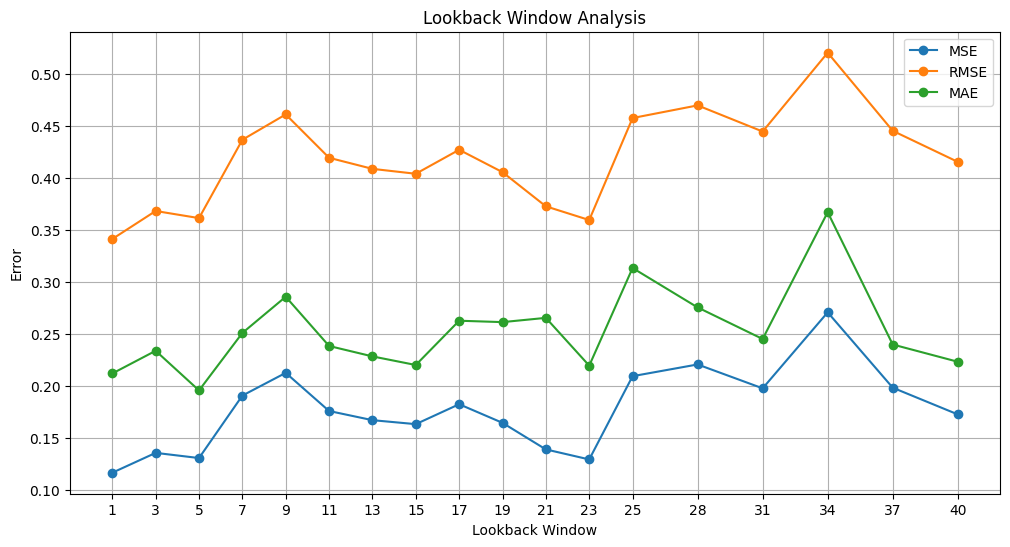

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

tf.config.experimental.enable_op_determinism()
tf.random.set_seed(7)
np.random.seed(7)


# Loading the dataset
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df

# Preprocessing data
def preprocess_data(df, lookback):
    sequences = []
    labels = []
    for i in range(len(df) - lookback):
        sequences.append(df['pm2_5'].iloc[i:i + lookback].values)
        labels.append(df['pm2_5'].iloc[i + lookback])

    return np.array(sequences), np.array(labels)

# Splitting data into training and testing sets
def split_data(df, train_ratio=0.9):
    train_size = int(len(df) * train_ratio)
    train, test = df[:train_size], df[train_size:]
    return train, test

# an actual build of the lstm model
def build_lstm_model(lookback):
    model = Sequential([
        Input(shape=(lookback, 1)),  # Explicit Input layer
        LSTM(50, activation='relu'),  # LSTM layer
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Evaluatiing the model
def evaluate_model(model, X_test, y_test, scaler):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    return mse, rmse, mae

# Lookback analysis for different lookback windows
def lookback_analysis(file_path):
    lookbacks = [1,3,5,7,9,11,13,15,17,19,21,23,25,28,31,34,37,40]
    mses = []
    rmses = []
    maes = []

    df = load_data(file_path)

    # Scale the full dataset first
    scaler = MinMaxScaler()
    df['pm2_5'] = scaler.fit_transform(df[['components.pm2_5']])  # Normalize the full dataset

    # Split the data into training and testing sets
    train, test = split_data(df)

    for lookback in lookbacks:
        # Preprocess the data (create sequences)
        X_train, y_train = preprocess_data(train, lookback)
        X_test, y_test = preprocess_data(test, lookback)

        # Reshape for LSTM input
        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

        model = build_lstm_model(lookback)
        model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), shuffle=False, verbose=0)

        mse, rmse, mae = evaluate_model(model, X_test, y_test, scaler)
        mses.append(mse)
        rmses.append(rmse)
        maes.append(mae)

        print(f"Lookback: {lookback}, MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

    # To plot the results
    plt.figure(figsize=(12, 6))
    plt.plot(lookbacks, mses, marker='o', label='MSE')
    plt.plot(lookbacks, rmses, marker='o', label='RMSE')
    plt.plot(lookbacks, maes, marker='o', label='MAE')
    plt.xlabel('Lookback Window')
    plt.ylabel('Error')
    plt.title('Lookback Window Analysis')
    plt.xticks(lookbacks)
    plt.legend()
    plt.grid(True)
    plt.show()


def main():
    file_path = 'air_quality_data.csv' 
    lookback_analysis(file_path)

if __name__ == "__main__":
    main()
